In [170]:
# import packages
import geopandas as gpd
import os
from requests import get
from urllib.parse import urlparse
import pandas as pd

In [171]:
def cache_data(src:str, dest:str) -> str:
    """
    Downloads a file from the given URL `src` and saves it to the `dest` directory.
    If the file already exists and is of sufficient size, skips the download.
    
    Args:
        src (str): The source URL of the file to be downloaded.
        dest (str): The destination directory where the file will be saved.
        
    Returns:
        str: The full path to the downloaded (or existing) file.
    """    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 250:
        
        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)
        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

In [172]:
# listing data,choose the data of 2024
ymd  = '20240614'
city = 'London'
host = 'https://orca.casa.ucl.ac.uk'
list_url  = f'{host}/~jreades/data/{ymd}-{city}-listings.parquet'
transport_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/Transport_Classification_of_Londoners_(TCoL)/Transport_Classification_of_Londoners_(TCoL).shp'
inequity_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/Borough_pages_data_UPDATE_9_2024_HACTAR(1).csv'
pop_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/population%20by%20borough.xlsx'
sta_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/London%20stations/London%20stations.shp'
line_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/London%20Train%20Lines/London%20Train%20Lines.shp'
borough_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/Boroughs.gpkg'

In [173]:
# the data frame of datas
listing_df = pd.read_parquet(cache_data(list_url, os.path.join('data','raw')))
# inequity data
inequity = pd.read_csv(cache_data(inequity_url, os.path.join('data','raw')),skiprows=11, header=0)
# population data
pop = pd.read_excel(cache_data(pop_url, os.path.join('data','raw')))
# borough outline
borough = gpd.read_file(cache_data(borough_url, os.path.join('data','raw')))

# station point data
station = gpd.read_file(sta_url)
# train line data
line = gpd.read_file(line_url)
# transport data, spatial unit is OA(output area)
transport = gpd.read_file(transport_url)

Found data/raw/20240614-London-listings.parquet locally!
Found data/raw/Borough_pages_data_UPDATE_9_2024_HACTAR(1).csv locally!
Found data/raw/population%20by%20borough.xlsx locally!
Found data/raw/Boroughs.gpkg locally!


In [174]:
# this is the columns list, if you want to focus on a certain topic, choose some of them
# listing data
columns_list = listing_df.columns.to_list()
print(f'listing data columns: {columns_list}')
print(f"Data frame is {listing_df.shape[0]:,} x {listing_df.shape[1]}")
# transport data
columns_transport = transport.columns.to_list()
print(f'transport data columns: {columns_transport}')
# inequity data
columns_inequity = inequity.columns.to_list()
print(f'inequity data columns: {columns_inequity}')
# population data
columns_pop = pop.columns.to_list()
print(f'population data columns: {columns_pop}')
# station data
columns_station = station.columns.to_list()
print(f'station data columns: {columns_station}')
# line data
columns_line = line.columns.to_list()
print(f'line data columns: {columns_line}')
# borough outline
columns_borough = borough.columns.to_list()
print(f'borough data columns: {columns_borough}')

listing data columns: ['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id', 'host_name', 'host_since', 'host_location', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 'first_review', 'last_review', 'review_scores_rating', 'reviews_per_month']
Data frame is 85,127 x 31
transport data columns: ['OBJECTID', 'TCOL_SEGME', 'TCOL_SEG_1', 'OA_POPULAT', 'SEGMENT_PO', 'LOAC_SUPER', 'LOAC_GROUP', 'LOAC_SUB_G', 'LOCAL_AUTH', 'PROPENSITY', 'PROPENSI_1', 'PROPENSI_2', 'PROPENSI_3', 'CAR_DRIVER', 'CAR_PASSEN', 'BUS_TRIPS_', 'TRAIN_TRIP', 'RIVER_TRIP', 'TRAM_TRIPS', 'TUBE_TRIPS', 'BICYCLE_TR', 'HIRE_BIKE_', 'DLR_TRIPS_', 'POWERED_TW', 'TAXI_PHV_T', 'WALK_TRIPS', 'CAR_AVAILA', 'AVERAGE_IN', 'STUDENT', 'NO_CHILDRE', 'NO_CHILD_1', 'NO

In [278]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from sklearn.decomposition import PCA
from shapely.geometry import Point
from esda import Moran, Moran_Local
from libpysal.weights import Queen, KNN
from splot.esda import moran_scatterplot, lisa_cluster
from esda.moran import Moran

In [279]:
#Choose 'price','accommodates', 'room_type' as clustering variables
data = listing_df[['price','accommodates', 'room_type', 'latitude', 'longitude']].copy()
data = data.dropna()

In [280]:
#Data cleansing (removal of outliers with a price of 0 or negative)
data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float) 
data = data[data['price'] > 0]  

In [281]:
# Take the logarithm of the price to reduce the impact of extreme values
data['log_price'] = np.log1p(data['price'])

In [282]:
clustering_vars = ['log_price', 'accommodates', 'room_type']
# Standardized numerical features and One-hot encoding category features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['log_price', 'accommodates']),  
        ('cat', OneHotEncoder(), ['room_type']) 
    ]
)

In [283]:
data_preprocessed = preprocessor.fit_transform(data)

In [284]:
#Use the elbow method to select the optimal number of clusters
sse = []
k_range = range(2, 10) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_preprocessed)
    sse.append(kmeans.inertia_) 


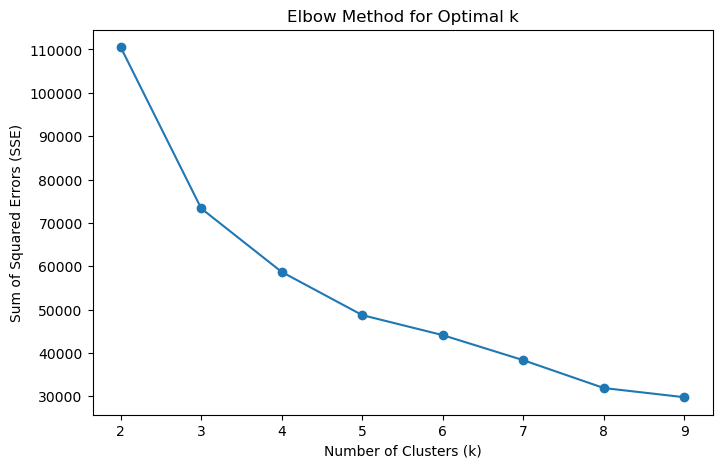

In [285]:
# Draw the elbow method diagram
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

In [286]:
#K-means
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['cluster'] = kmeans.fit_predict(data_preprocessed)

In [287]:
#Use PCA to reduce the dimensionality of data to 2D for easy visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_preprocessed)
data['pca_1'] = data_pca[:, 0]
data['pca_2'] = data_pca[:, 1]

In [288]:
borough_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/Boroughs.gpkg'
boroughs = gpd.read_file(borough_url)
print(boroughs.head())
print(boroughs.crs)

                   NAME   GSS_CODE   HECTARES  NONLD_AREA ONS_INNER  \
0  Kingston upon Thames  E09000021   3726.117       0.000         F   
1               Croydon  E09000008   8649.441       0.000         F   
2               Bromley  E09000006  15013.487       0.000         F   
3              Hounslow  E09000018   5658.541      60.755         F   
4                Ealing  E09000009   5554.428       0.000         F   

                                            geometry  
0  MULTIPOLYGON (((516401.6 160201.8, 516407.3 16...  
1  MULTIPOLYGON (((535009.2 159504.7, 535005.5 15...  
2  MULTIPOLYGON (((540373.6 157530.4, 540361.2 15...  
3  MULTIPOLYGON (((521975.8 178100, 521967.7 1780...  
4  MULTIPOLYGON (((510253.5 182881.6, 510249.9 18...  
EPSG:27700


In [289]:
#Convert the CRS of Boroughs.gpkg from EPSG:27700 to EPSG:4326
boroughs = boroughs.to_crs('EPSG:4326')
print(boroughs.crs)

EPSG:4326


In [290]:
#Create a GeoDataFrame containing latitude and longitude
geo_data = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data['longitude'], data['latitude']))
geo_data = geo_data.set_crs('EPSG:4326', allow_override=True)
print(geo_data)

       price  accommodates        room_type   latitude  longitude  log_price  \
0       42.0             2     Private room  51.442010  -0.187390   3.761200   
1      175.0             5  Entire home/apt  51.499930  -0.217070   5.170484   
2       79.0             1     Private room  51.568610  -0.112700   4.382027   
3      150.0             2  Entire home/apt  51.487800  -0.168130   5.017280   
4       46.0             2     Private room  51.476180   0.014420   3.850148   
...      ...           ...              ...        ...        ...        ...   
85122  119.0             6  Entire home/apt  51.410424  -0.183070   4.787492   
85123  275.0             3  Entire home/apt  51.514860  -0.135980   5.620401   
85124  145.0             2  Entire home/apt  51.459042  -0.055458   4.983607   
85125  680.0            10  Entire home/apt  51.450997  -0.444319   6.523562   
85126  170.0             6  Entire home/apt  51.515970  -0.111342   5.141664   

       cluster     pca_1     pca_2     

In [291]:
# Delete the 'index_right' column that may already exist
if 'index_right' in geo_data.columns:
    geo_data = geo_data.drop(columns=['index_right'])
if 'index_right' in boroughs.columns:
    boroughs = boroughs.drop(columns=['index_right'])
# Perform spatial join
geo_data = gpd.sjoin(geo_data, boroughs, how='inner', predicate='within')
print(geo_data.head())

   price  accommodates        room_type  latitude  longitude  log_price  \
0   42.0             2     Private room  51.44201   -0.18739   3.761200   
1  175.0             5  Entire home/apt  51.49993   -0.21707   5.170484   
2   79.0             1     Private room  51.56861   -0.11270   4.382027   
3  150.0             2  Entire home/apt  51.48780   -0.16813   5.017280   
4   46.0             2     Private room  51.47618    0.01442   3.850148   

   cluster     pca_1     pca_2                   geometry  index_right  \
0        1 -1.520096  0.458235  POINT (-0.18739 51.44201)           21   
1        0  1.094476  0.292654  POINT (-0.21707 51.49993)           22   
2        1 -1.360408 -0.395922   POINT (-0.1127 51.56861)           27   
3        2 -0.014457 -0.720706   POINT (-0.16813 51.4878)           23   
4        1 -1.450021  0.389876   POINT (0.01442 51.47618)           13   

                     NAME   GSS_CODE  HECTARES  NONLD_AREA ONS_INNER  
0              Wandsworth  E09000

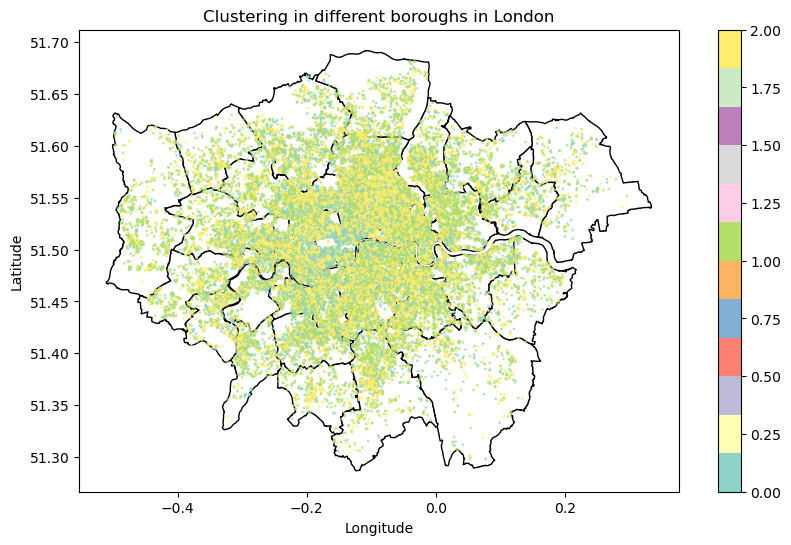

In [292]:
fig, ax = plt.subplots(figsize=(10, 6))
# Draw administrative districts
boroughs.plot(ax=ax, color='white', edgecolor='black')
# Draw each housing point and color it according to the clustering results
geo_data.plot(ax=ax, column='cluster', cmap='Set3', legend=True, markersize=1, alpha=0.6)

plt.title('Clustering in different boroughs in London')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [293]:
# Merge 'cluster' column into 'boroughs' by clustering results
boroughs = boroughs.join(geo_data['cluster'], how='left')

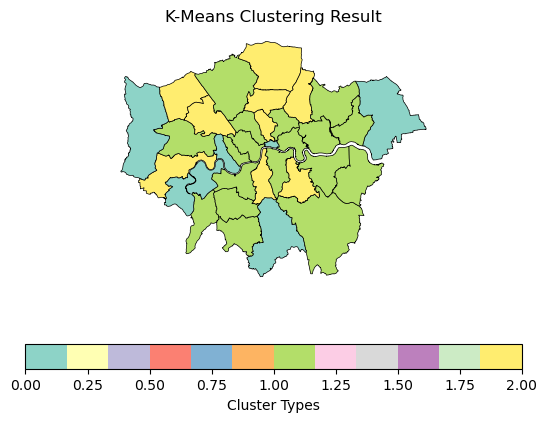

In [294]:
if 'index_right' in geo_data.columns:
    geo_data = geo_data.drop(columns=['index_right'])
if 'index_right' in boroughs.columns:
    boroughs = boroughs.drop(columns=['index_right'])
    
geo_data = gpd.sjoin(geo_data, boroughs, how='inner', predicate='within')

# Visualization
boroughs.plot(
    column='cluster', 
    cmap='Set3', 
      legend=True, 
    legend_kwds={'label': "Cluster Types", 'orientation': "horizontal"},
    edgecolor='black',  
    linewidth=0.5
)
plt.title('K-Means Clustering Result')
plt.axis('off')
plt.show()


In [295]:
# Perform statistical analysis on samples in each cluster
cluster_data = data.groupby('cluster').describe()
print(cluster_data)


           price                                                       \
           count        mean          std   min    25%    50%     75%   
cluster                                                                 
0        18224.0  464.458242  1001.596439   8.0  200.0  300.0  455.00   
1        29118.0   59.700048    30.610866   1.0   39.0   52.0   74.00   
2        37782.0  143.690832    74.666499  15.0   95.0  130.0  175.75   

                 accommodates            ...     pca_1              pca_2  \
             max        count      mean  ...       75%       max    count   
cluster                                  ...                                
0        80100.0      18224.0  5.930147  ...  2.183422  7.902973  18224.0   
1          250.0      29118.0  1.783879  ... -1.092416  0.261386  29118.0   
2         1100.0      37782.0  2.978005  ...  0.606972  1.347790  37782.0   

                                                                               
             mean 

In [296]:
# Select numerical data (price and acommodates)
data_numeric = data.select_dtypes(include=[float, int])
# Perform statistical analysis of numerical features for each cluster
cluster_means = data_numeric.groupby('cluster').mean()
print(cluster_means)

              price  accommodates   latitude  longitude  log_price     pca_1  \
cluster                                                                        
0        464.458242      5.930147  51.508723  -0.137975   5.799506  1.868533   
1         59.700048      1.783879  51.509627  -0.118972   3.993596 -1.399129   
2        143.690832      2.978005  51.509613  -0.130555   4.869630  0.177007   

            pca_2  
cluster            
0        0.171476  
1        0.194415  
2       -0.232544  


In [297]:
# Perform clustering statistics on 'room_type'
room_type_stats = data.groupby('cluster')['room_type'].value_counts(normalize=True).unstack().fillna(0)

print("\nRoom Type Distribution by Cluster:")
print(room_type_stats)



Room Type Distribution by Cluster:
room_type  Entire home/apt  Hotel room  Private room  Shared room
cluster                                                          
0                 0.942987    0.003841      0.051086     0.002085
1                 0.012535    0.001099      0.977265     0.009101
2                 0.970118    0.003070      0.025832     0.000979


In [298]:
# Import train line and station data
train_lines = gpd.read_file("Chocolate/London Train Lines/London Train Lines.shp")
stations = gpd.read_file("Chocolate/London Stations/London stations.shp")


In [299]:
geo_data = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data['longitude'], data['latitude']),
    crs="EPSG:4326" 
)

In [300]:
#Convert GeoDataFrame's CRS
geo_data_projected = geo_data.to_crs("EPSG:27700")
train_lines_projected = train_lines.to_crs("EPSG:27700")
stations_projected = stations.to_crs("EPSG:27700")

In [301]:
# Find the nearest train station for each clustering point
geo_data_with_stations = gpd.sjoin_nearest(geo_data_projected, stations_projected, how="left", distance_col="distance_to_station")

print(geo_data_with_stations.head())

   price  accommodates        room_type  latitude  longitude  log_price  \
0   42.0             2     Private room  51.44201   -0.18739   3.761200   
1  175.0             5  Entire home/apt  51.49993   -0.21707   5.170484   
2   79.0             1     Private room  51.56861   -0.11270   4.382027   
3  150.0             2  Entire home/apt  51.48780   -0.16813   5.017280   
4   46.0             2     Private room  51.47618    0.01442   3.850148   

   cluster     pca_1     pca_2                       geometry  index_right  \
0        1 -1.520096  0.458235  POINT (526071.772 173004.347)          174   
1        0  1.094476  0.292654  POINT (523852.404 179394.541)          310   
2        1 -1.360408 -0.395922  POINT (530899.228 187213.456)          149   
3        2 -0.014457 -0.720706  POINT (527282.901 178129.531)          501   
4        1 -1.450021  0.389876  POINT (539991.817 177170.364)          632   

                   Name                                               Link  \
0 

In [302]:
# Create a buffer zone for the train line (e.g. 500 meters)
train_lines_buffer = train_lines_projected.buffer(500)
#Convert buffer to GeoDataFrame
train_lines_buffer_gdf = gpd.GeoDataFrame(geometry=train_lines_buffer, crs="EPSG:27700")
geo_data_with_train_lines = gpd.sjoin(geo_data_projected, train_lines_buffer_gdf, how="inner", predicate="intersects")
#Perform spatial connection and find the intersection of clustering points and buffers
print(geo_data_with_train_lines.head())


   price  accommodates        room_type  latitude  longitude  log_price  \
0   42.0             2     Private room  51.44201   -0.18739   3.761200   
0   42.0             2     Private room  51.44201   -0.18739   3.761200   
0   42.0             2     Private room  51.44201   -0.18739   3.761200   
0   42.0             2     Private room  51.44201   -0.18739   3.761200   
1  175.0             5  Entire home/apt  51.49993   -0.21707   5.170484   

   cluster     pca_1     pca_2                       geometry  index_right  
0        1 -1.520096  0.458235  POINT (526071.772 173004.347)          739  
0        1 -1.520096  0.458235  POINT (526071.772 173004.347)          740  
0        1 -1.520096  0.458235  POINT (526071.772 173004.347)          738  
0        1 -1.520096  0.458235  POINT (526071.772 173004.347)          737  
1        0  1.094476  0.292654  POINT (523852.404 179394.541)         1024  


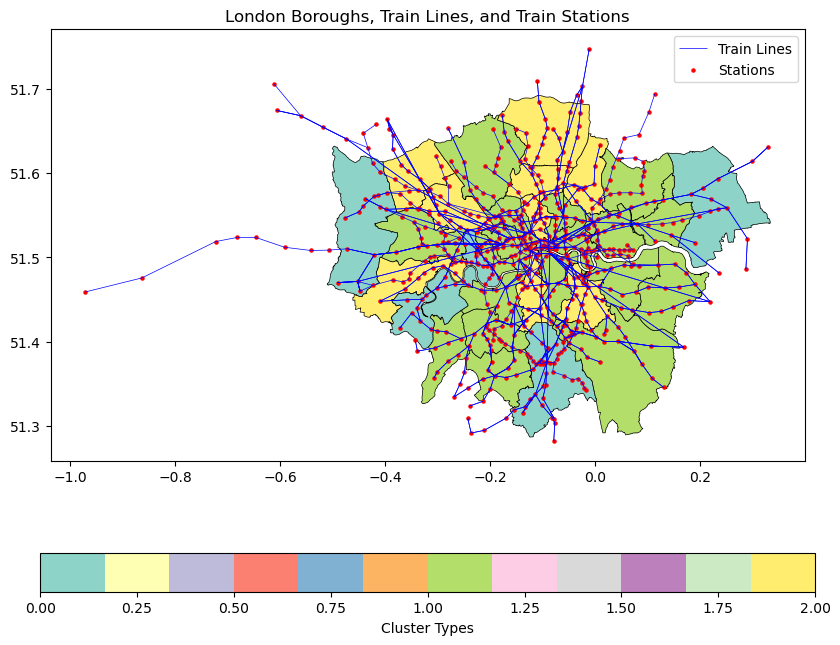

In [303]:
# Convert projection data back to geographic coordinate system
geo_data_with_stations = geo_data_with_stations.to_crs("EPSG:4326")
train_lines = train_lines.to_crs("EPSG:4326")
stations = stations.to_crs("EPSG:4326")

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))
boroughs.plot(
    ax=ax, 
    column='cluster', 
    cmap='Set3', 
    legend=True, 
    legend_kwds={'label': "Cluster Types", 'orientation': "horizontal"},
    edgecolor='black',  
    linewidth=0.5
)

train_lines.plot(ax=ax, color="blue", linewidth=0.5, label="Train Lines")

stations.plot(ax=ax, color="red", markersize=5, label="Stations")


plt.title("London Boroughs, Train Lines, and Train Stations")
plt.legend()
plt.show()

In [304]:
#Construct a weight matrix based on train lines, stations or point adjacencies
#Construct a weight matrix (based on clustering points)
w = Queen.from_dataframe(geo_data)

print(w)

/tmp/ipykernel_163/11413205.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(geo_data)


In [305]:
# Calculate Moran's I
moran = Moran(geo_data['cluster'], w)

print(f"Moran's I: {moran.I}, p-value: {moran.p_sim}")


Moran's I: 0.09786165669075474, p-value: 0.001


In [310]:
tcol_data= gpd.read_file("Chocolate/Transport_Classification_of_Londoners_(TCoL)/Transport_Classification_of_Londoners_(TCoL).shp")

In [311]:
# Convert geo_data to the same CRS as tcol_data (EPSG:27700)
geo_data = geo_data.to_crs('EPSG:27700')

geo_data_with_tcol = gpd.sjoin(geo_data, tcol_data, how='left', predicate='within')

print(geo_data_with_tcol.head())


   price  accommodates        room_type  latitude  longitude  log_price  \
0   42.0             2     Private room  51.44201   -0.18739   3.761200   
1  175.0             5  Entire home/apt  51.49993   -0.21707   5.170484   
2   79.0             1     Private room  51.56861   -0.11270   4.382027   
3  150.0             2  Entire home/apt  51.48780   -0.16813   5.017280   
4   46.0             2     Private room  51.47618    0.01442   3.850148   

   cluster     pca_1     pca_2                       geometry  ...  \
0        1 -1.520096  0.458235  POINT (526071.772 173004.347)  ...   
1        0  1.094476  0.292654  POINT (523852.404 179394.541)  ...   
2        1 -1.360408 -0.395922  POINT (530899.228 187213.456)  ...   
3        2 -0.014457 -0.720706  POINT (527282.901 178129.531)  ...   
4        1 -1.450021  0.389876  POINT (539991.817 177170.364)  ...   

   INCREASE_1  INCREASE_2 INCREASE_3 INCREASE_4      OA_ID  \
0         116         171        113        171  E00022589   
1   

In [316]:
import geopandas as gpd
import pysal
from pysal.explore import esda
# Calculate the weight matrix, using Queen's rule (neighborhood definition)
w = pysal.lib.weights.Queen.from_dataframe(geo_data_with_tcol)

# Calculate Moran index
morans_i = esda.Moran(geo_data_with_tcol['cluster'], w)


print(f"Moran's I: {morans_i.I}")
print(f"p-value: {morans_i.p_sim}")


/tmp/ipykernel_163/4204320691.py:8: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = pysal.lib.weights.Queen.from_dataframe(geo_data_with_tcol)


Moran's I: 0.1058412141434195
p-value: 0.001
